TODO

- Parameter analysis and optimization - block - done
- Train test percentage with plot - block - donee
- Results with confidence intervals - run 100 times, save results, plot - Donee

In [1]:
# Module Imports

import os
import time
import gc

import numpy as np

import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

import keras

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef


import matplotlib.pyplot as plt
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-06-05 09:30:06.713417: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 09:30:06.723982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749105006.735022  233872 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749105006.738126  233872 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749105006.746523  233872 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Hyperparameters and Parameters

# Change paramers as needed. 
# - To run on other datasets, change 'data_path'
# - To use early stopping, set 'EarlyStopping' to True
# - To use hyperparameter tuning, set 'tuner' to True

params = {
    'data_path': 'data/micro',
    'image_size': (128, 128),
    'batch_size': 32,
    'epochs': 30,
    'test_split': 0.2,
    'validation_split': 0.1,
    'random_seed': 42,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'shuffle': True,
    'EarlyStopping': False,
    'tuner': False,
    'verbose': False
}

In [3]:
# Load and Split Data

def get_dataset():
    # Load dataset
    dataset = image_dataset_from_directory(
        params['data_path'],
        image_size=params['image_size'],
        batch_size=params['batch_size'],
        seed=params['random_seed']
    )

    # Shuffle it before splits
    dataset.shuffle(params['shuffle'])

    # Split into training, testing and validation
    train_ds = dataset.take(int((1 - params['test_split']) * len(dataset)))
    test_ds = dataset.skip(int((1 - params['test_split']) * len(dataset)))
    test_ds = test_ds.take(int((1 - params['validation_split']) * len(test_ds)))
    validation_ds = test_ds.skip(int((1 - params['validation_split']) * len(test_ds)))


    class_names = dataset.class_names
    class_counts = {cls: len(os.listdir(os.path.join(params['data_path'], cls))) for cls in class_names}

    return dataset,train_ds, test_ds, validation_ds, class_names, class_counts

In [4]:
# Build CNN Model

def build_CNN_model(train_ds, validation_ds, class_names):

    # Hyperparameter Optimization 
    # def build_model_hp(hp):
    #     model = models.Sequential()
    #     model.add(layers.Input(shape=(*params['image_size'], 3)))
    #     model.add(layers.Conv2D(hp.Int('conv_1', 8, 128, step=8), (3, 3), activation='relu'))
    #     model.add(layers.MaxPooling2D(2, 2))
    #     model.add(layers.Conv2D(hp.Int('conv_2', 8, 128, step=8), (3, 3), activation='relu'))
    #     model.add(layers.MaxPooling2D(2, 2))
    #     model.add(layers.Flatten())
    #     model.add(layers.Dense(hp.Int('dense', 8, 128, step=8), activation='relu'))
    #     model.add(layers.Dense(len(class_names), activation='softmax'))
    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-1, 1e-2, 1e-3, 1e-4])),
    #         loss='sparse_categorical_crossentropy',
    #         metrics=['accuracy']
    #     )
    #     return model

    def build_model_hp(hp):
        model = models.Sequential()
        model.add(layers.Input(shape=(*params['image_size'], 3)))

        # First conv layer
        model.add(layers.Conv2D(
            hp.Int('conv_1', 8, 128, step=16),
            (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))

        # Optional second conv layer
        if hp.Boolean('use_conv_2'):
            model.add(layers.Conv2D(
                hp.Int('conv_2', 8, 128, step=16),
                (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D(2, 2))

        # Optional third conv layer
        if hp.Boolean('use_conv_3'):
            model.add(layers.Conv2D(
                hp.Int('conv_3', 8, 128, step=16),
                (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D(2, 2))

        model.add(layers.Flatten())

        # First dense layer
        model.add(layers.Dense(
            hp.Int('dense_1', 8, 128, step=16),
            activation='relu'))

        # Optional second dense layer
        if hp.Boolean('use_dense_2'):
            model.add(layers.Dense(
                hp.Int('dense_2', 8, 128, step=16),
                activation='relu'))

        # Output layer
        model.add(layers.Dense(len(class_names), activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('lr', [1e-1, 1e-2, 1e-3])
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_model_standard(num_classes):
        model = models.Sequential([
            layers.Input(shape=(*params['image_size'], 3)),
            # layers.Rescaling(1./255, input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            #layers.Conv2D(128, (3, 3), activation='relu'),
            #layers.MaxPooling2D(),
            layers.Flatten(),
            #layers.Dense(256, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    if params['tuner']:
        # tuner = kt.Hyperband(build_model_hp, objective='val_accuracy', max_epochs=params['epochs'], directory='kt_dir', project_name='cnn_tune')
        # tuner.search(train_ds, validation_data=validation_ds, epochs=params['epochs'])
        # model = tuner.get_best_models(1)[0]

        # model.summary()

        tuner = kt.Hyperband(
            build_model_hp,
            objective='val_accuracy',
            max_epochs=params['epochs'],
            directory='kt_dir',
            project_name='cnn_tune'
        )

        # Run the hyperparameter search
        tuner.search(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs']
        )

        # Retrieve the best model
        model = tuner.get_best_models(1)[0]

        # Optionally retrieve best hyperparameters
        best_hps = tuner.get_best_hyperparameters(1)[0]

        print("Best hyperparameters:")
        print(best_hps.values)
        
    else:
        num_classes = len(class_names)
        model = build_model_standard(num_classes = num_classes)

    return model

In [5]:
#  Model Training with params
def train_model(model, train_ds, validation_ds):

    if params['EarlyStopping']:
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        start_train = time.time()

        history = model.fit(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs'],
            callbacks=[early_stop],
            verbose=0
        )

        end_train = time.time()
    else:
        early_stop = None

        start_train = time.time()

        history = model.fit(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs'],
            verbose=0
        )
        end_train = time.time()

    print(f"Training time: {end_train - start_train:.2f} seconds")

    return model, history

In [6]:
# Evaluate & Metrics 

def evaluate_model(model, test_ds, verbose=True):

    true_labels, pred_labels = [], []
    start_test = time.time()
    for images, labels in test_ds.unbatch():
        preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
        true_labels.append(labels.numpy())
        pred_labels.append(np.argmax(preds))
    end_test = time.time()



    results = {
        'True_Labels': true_labels,
        'Predicted_Labels': pred_labels,
        'Accuracy': accuracy_score(true_labels, pred_labels),
        'Precision': precision_score(true_labels, pred_labels, average='macro'),
        'Recall': recall_score(true_labels, pred_labels, average='macro'),
        'F1': f1_score(true_labels, pred_labels, average='macro'),
        'Kappa': cohen_kappa_score(true_labels, pred_labels),
        'MCC': matthews_corrcoef(true_labels, pred_labels)}
    
    if verbose:
        # print("True Labels:", true_labels)
        # print("Predicted Labels:", pred_labels)
        print(f"Testing time: {end_test - start_test:.2f} seconds")
    
        print("Evaluation Results:")
        for key, value in results.items():
            print(f"{key}: {value}")

    return results

In [7]:
# Additional Plots 

def additional_plots(model, history, class_names, class_counts, results, verbose=True):
    
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 14
    })
    
    plt.figure(figsize=(10, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Dataset Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
    plt.grid(True)
    plt.savefig("figs/class_distribution.pdf", format='pdf', bbox_inches='tight')


    cm = confusion_matrix(results['True_Labels'], results['Predicted_Labels'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
    plt.savefig("figs/confiusion_matrix_tuner_" + str(params["tuner"]) + ".pdf", format='pdf', bbox_inches='tight')

In [ ]:
# Main Function without Hyperparameter Tuning

params['tuner'] = False
params['test_split'] = 0.2

dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()

model = build_CNN_model(train_ds, validation_ds, class_names)

model, history = train_model(model, train_ds, validation_ds)

results = evaluate_model(model, test_ds, verbose=params['verbose'])

additional_plots(model, history, class_names, class_counts, results)

In [ ]:
params['tuner'] = False
additional_plots(model, history, class_names, class_counts, results)

In [ ]:
# Main Function with Hyperparameter Tuning
!rm -rf ./kt_dir

params['tuner'] = True

dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()

model = build_CNN_model(train_ds, validation_ds, class_names)

model, history = train_model(model, train_ds, validation_ds)

results = evaluate_model(model, test_ds, verbose=params['verbose'])

additional_plots(model, history, class_names, class_counts, results)

params['tuner'] = False


dditional_plots(model, history, class_names, class_counts, results)

In [ ]:
# Train / test percentage experiment

params['tuner'] = False
params['test_split'] = 0.2

exp_results = {}

for i in np.arange(0.1, 1.0, 0.1):
    params['test_split'] = i
    print(f"Train_percent: {1-params['test_split']}, Test_percent: {params['test_split']}")

    dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()
    model = build_CNN_model(train_ds, validation_ds, class_names)
    model, history = train_model(model, train_ds, validation_ds)
    results = evaluate_model(model, test_ds, verbose=params['verbose'])
    exp_results[f"Test_percent: {params['test_split']}"] = results
    # additional_plots(model, history, class_names, class_counts, results)

    gc.collect()
    tf.keras.backend.clear_session()

In [ ]:
x_labels = [f"[{1 - test:.1f} / {test:.1f}]" for test in np.arange(0.1, 1.0, 0.1)]
accuracies = [result['Accuracy'] for result in exp_results.values()]

# set all parameters for plot, including text sizes for everything

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 14
})

plt.figure(figsize=(8, 6))
#plt.bar(x_labels, accuracies)
plt.plot(x_labels, accuracies, marker='o', linewidth=2)
plt.xlabel('Train [%] / Test [%]')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Train / Test Percentages')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.savefig("figs/accuracy_percent_plot.pdf", format='pdf', bbox_inches='tight')

In [8]:
# Confidence Interval Experiment

exp_results = {}

params['tuner'] = False
params['test_split'] = 0.2

for i in range(100):
    dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()
    model = build_CNN_model(train_ds, validation_ds, class_names)
    model, history = train_model(model, train_ds, validation_ds)
    results = evaluate_model(model, test_ds, verbose=params['verbose'])
    exp_results[i] = results

    gc.collect()
    tf.keras.backend.clear_session()

Found 571 files belonging to 6 classes.


2025-06-05 09:30:40.711526: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-05 09:30:40.711551: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-06-05 09:30:40.711556: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-06-05 09:30:40.711558: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-06-05 09:30:40.711561: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: user-MS-7E26
2025-06-05 09:30:40.711563: I external/local_xla/xla/stream_executor/cuda/

Training time: 120.18 seconds


2025-06-05 09:32:44.885446: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 113.80 seconds


2025-06-05 09:34:42.865219: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 183.34 seconds
Found 571 files belonging to 6 classes.
Training time: 199.62 seconds


2025-06-05 09:41:28.397023: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 209.60 seconds
Found 571 files belonging to 6 classes.
Training time: 197.01 seconds
Found 571 files belonging to 6 classes.
Training time: 186.19 seconds
Found 571 files belonging to 6 classes.
Training time: 176.66 seconds


2025-06-05 09:54:46.439991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 157.94 seconds
Found 571 files belonging to 6 classes.
Training time: 146.16 seconds
Found 571 files belonging to 6 classes.
Training time: 131.95 seconds
Found 571 files belonging to 6 classes.
Training time: 150.26 seconds
Found 571 files belonging to 6 classes.
Training time: 114.83 seconds
Found 571 files belonging to 6 classes.
Training time: 115.23 seconds
Found 571 files belonging to 6 classes.
Training time: 120.99 seconds
Found 571 files belonging to 6 classes.
Training time: 116.91 seconds


2025-06-05 10:13:05.195863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 120.98 seconds
Found 571 files belonging to 6 classes.
Training time: 116.74 seconds
Found 571 files belonging to 6 classes.
Training time: 112.96 seconds
Found 571 files belonging to 6 classes.
Training time: 112.58 seconds
Found 571 files belonging to 6 classes.
Training time: 115.75 seconds
Found 571 files belonging to 6 classes.
Training time: 114.93 seconds
Found 571 files belonging to 6 classes.
Training time: 113.78 seconds
Found 571 files belonging to 6 classes.
Training time: 115.64 seconds
Found 571 files belonging to 6 classes.
Training time: 113.72 seconds


/home/roland/CNN_exp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 571 files belonging to 6 classes.
Training time: 110.51 seconds
Found 571 files belonging to 6 classes.
Training time: 113.88 seconds
Found 571 files belonging to 6 classes.
Training time: 114.78 seconds
Found 571 files belonging to 6 classes.
Training time: 119.86 seconds
Found 571 files belonging to 6 classes.
Training time: 118.95 seconds
Found 571 files belonging to 6 classes.
Training time: 112.62 seconds
Found 571 files belonging to 6 classes.
Training time: 114.74 seconds


2025-06-05 10:44:58.010572: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/roland/CNN_exp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 571 files belonging to 6 classes.
Training time: 113.72 seconds
Found 571 files belonging to 6 classes.
Training time: 115.79 seconds
Found 571 files belonging to 6 classes.
Training time: 118.85 seconds
Found 571 files belonging to 6 classes.
Training time: 117.84 seconds
Found 571 files belonging to 6 classes.
Training time: 115.90 seconds
Found 571 files belonging to 6 classes.
Training time: 112.73 seconds
Found 571 files belonging to 6 classes.
Training time: 115.81 seconds
Found 571 files belonging to 6 classes.
Training time: 110.69 seconds
Found 571 files belonging to 6 classes.
Training time: 117.66 seconds
Found 571 files belonging to 6 classes.
Training time: 114.52 seconds
Found 571 files belonging to 6 classes.
Training time: 109.65 seconds
Found 571 files belonging to 6 classes.
Training time: 113.71 seconds
Found 571 files belonging to 6 classes.
Training time: 111.79 seconds
Found 571 files belonging to 6 classes.
Training time: 115.75 seconds
Found 571 files belo

2025-06-05 11:48:22.279034: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 571 files belonging to 6 classes.
Training time: 116.86 seconds
Found 571 files belonging to 6 classes.
Training time: 118.93 seconds
Found 571 files belonging to 6 classes.
Training time: 109.69 seconds
Found 571 files belonging to 6 classes.
Training time: 110.65 seconds
Found 571 files belonging to 6 classes.
Training time: 117.86 seconds
Found 571 files belonging to 6 classes.
Training time: 113.73 seconds
Found 571 files belonging to 6 classes.
Training time: 111.65 seconds
Found 571 files belonging to 6 classes.
Training time: 113.77 seconds
Found 571 files belonging to 6 classes.
Training time: 114.80 seconds
Found 571 files belonging to 6 classes.
Training time: 114.78 seconds
Found 571 files belonging to 6 classes.
Training time: 111.53 seconds
Found 571 files belonging to 6 classes.
Training time: 110.73 seconds
Found 571 files belonging to 6 classes.
Training time: 113.82 seconds
Found 571 files belonging to 6 classes.
Training time: 109.61 seconds
Found 571 files belo

Mean Accuracy: 0.9925
Standard Deviation: 0.0292


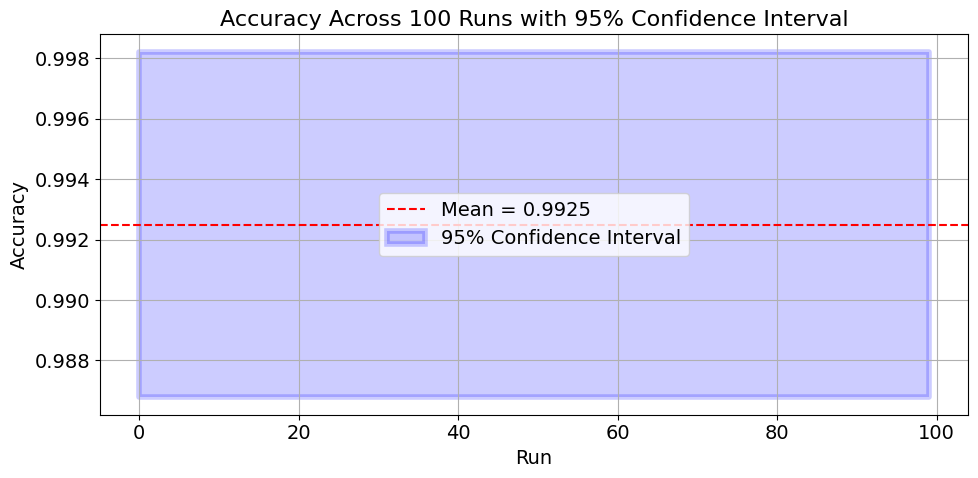

In [20]:

accuracies = [result['Accuracy'] for result in exp_results.values()]
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

mean = np.mean(accuracies)
std = np.std(accuracies)
n = len(accuracies)
ci95 = 1.96 * std / np.sqrt(n)

x = np.arange(n)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 14
})

plt.figure(figsize=(10, 5))
# plt.plot(x, accuracies, label='Accuraccy')
plt.axhline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')

# line plot with 95% confidence interval
#sns.lineplot(data=x, x="year", y="passengers", errorbar=("ci", 90))
plt.fill_between(x, mean - ci95, mean + ci95, color='blue', alpha=0.2, label='95% Confidence Interval', linewidth=4)
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Across 100 Runs with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_ci_plot.pdf", format='pdf', bbox_inches='tight')